In [725]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [726]:
tweets= pd.read_csv('../data/chesou.csv')
start_time=datetime(2015,10,3,17,30,0)

In [727]:
tweets['created_at'] = pd.to_datetime(pd.Series(tweets['created_at'])).apply(lambda d: d + timedelta(hours=1))

In [728]:
fh_added_time=2
sh_added_time=10
threshold=1

In [729]:
def to_min_soccer(d):
    d = d + timedelta(seconds=threshold*60)
    minute = float((86400* (d-start_time).days + (d-start_time).seconds)/60)
    if minute > 45 and minute <= 60:
        minute = 45+(minute-45)/100
    if minute > 60:
        minute = minute - 15 - fh_added_time
    
    if minute > 90:
        minute = 90 + (minute-90)/100
    return minute

In [730]:
def to_min(d):
    d = d + timedelta(seconds=threshold*60)
    minute = (86400* (d-start_time).days + (d-start_time).seconds)/60
    return minute

In [731]:
def filter_tweets_all(tweets):
    filtered = tweets[tweets['minute'] > 0]
    filtered = filtered[filtered['minute'] < 100]
    #return filtered
    #filtered = filtered[(filtered['text'].str.contains('CHEARS'))]
    #filtered = filtered[(filtered['text'].str.contains('CFC')) 
    #                   | (filtered['text'].str.contains('AFC'))
    #                  ]
    return filtered

In [732]:
def filter_tweets_divided(tweets):
    filtered = tweets[tweets['m'] > 0]
    filtered = filtered[filtered['m'] < 120]
    #return filtered
    #filtered = filtered[(filtered['text'].str.contains('CHEARS'))]
    #filtered = filtered[(filtered['text'].str.contains('CFC')) 
    #                   | (filtered['text'].str.contains('AFC'))
    #                  ]
    return filtered

In [733]:
def half_tweets(tweets):
    first_half = tweets[tweets['m']< 50]
    second_half = tweets[(tweets['m'] > 60) & (tweets['m'] < 120)]
    return first_half, second_half

In [734]:
tweets['minute']=tweets.created_at.apply(to_min_soccer)
tweets['m']=tweets.created_at.apply(to_min)

In [735]:
first_half, second_half = half_tweets(tweets)
fh_filtered=filter_tweets_divided(first_half)
sh_filtered=filter_tweets_divided(second_half)
sh_filtered['m'] = sh_filtered.m.apply(lambda d: d - 15 - fh_added_time)

In [736]:
filtered = filter_tweets_all(tweets)

In [737]:
grouped_all = filtered.groupby('minute').count()
grouped_fh = fh_filtered.groupby('m').count()
grouped_sh = sh_filtered.groupby('m').count()

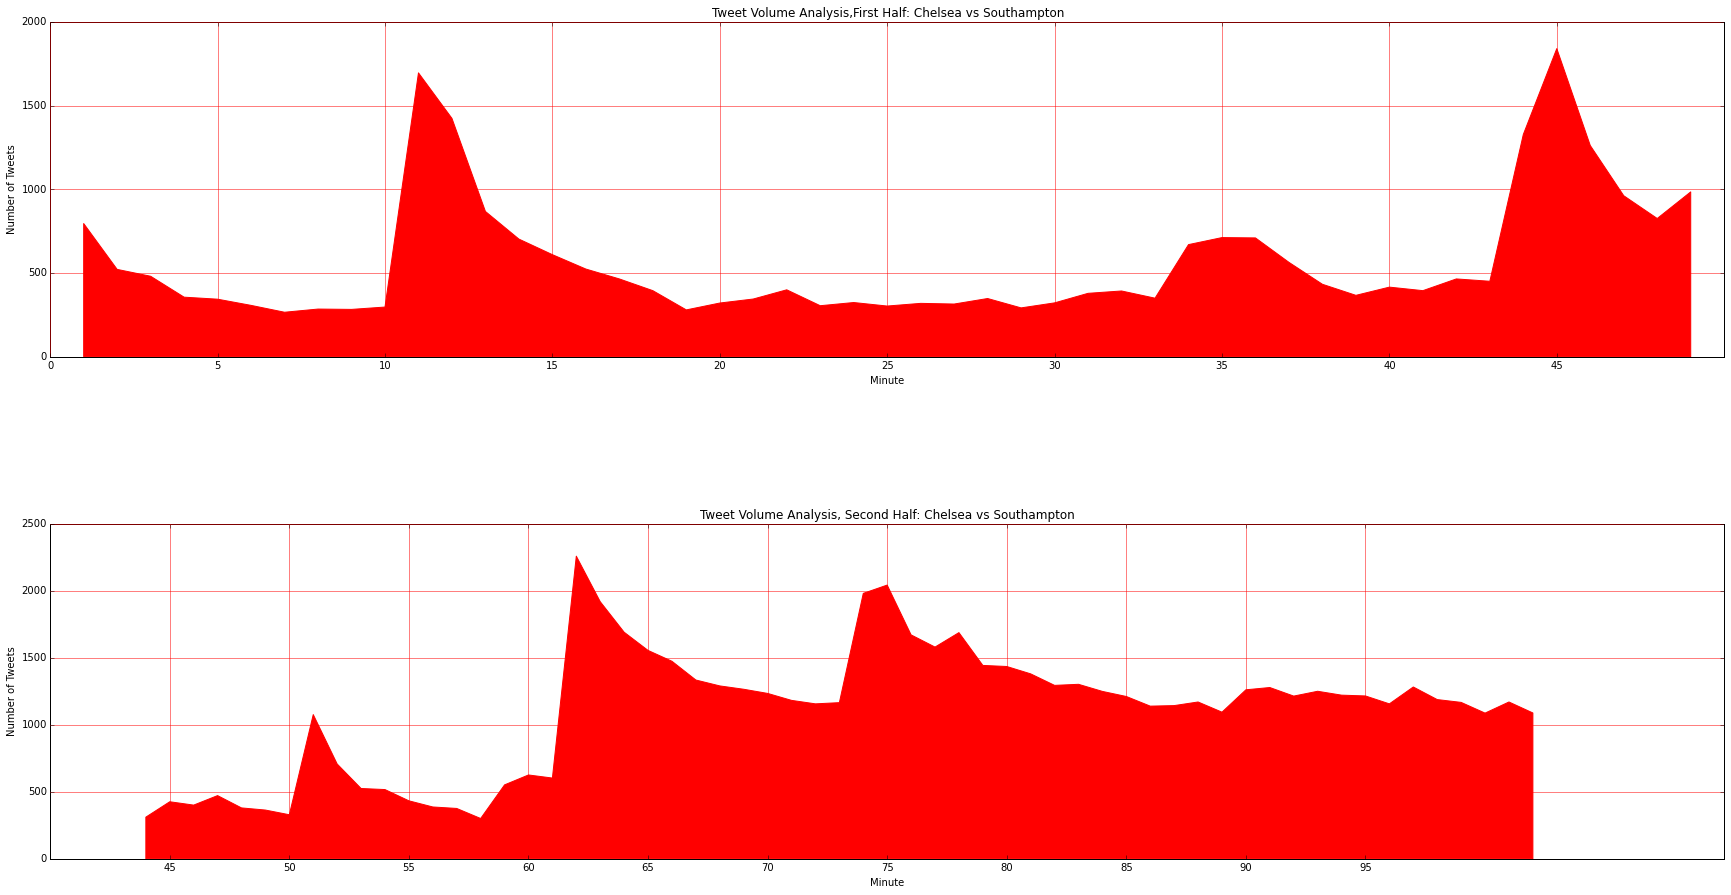

In [738]:
# let us make a simple graphfh
fig = plt.figure(figsize=[30,15])
plt.subplots_adjust(hspace=.5)

# set the grid on
plt.grid(color='r', linestyle='-', linewidth=0.5, which='major')
plt.xticks(range(0,100,5))


plt.subplot2grid((2,2), (0,0), colspan=2)
plt.fill_between(grouped_fh.index, grouped_fh['text'], color='red')
# set the basic properties
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.title('Tweet Volume Analysis,First Half: Chelsea vs Southampton')
# set the limits
#ax.set_xlim(0, 24)
#ax.set_ylim(6, 24)

# set the grid on
plt.grid(color='r', linestyle='-', linewidth=0.5, which='major')
plt.xticks(range(0,50,5))

plt.subplot2grid((2,2), (1,0), colspan=2)
plt.fill_between(grouped_sh.index, grouped_sh['text'], color='red')
# set the basic properties
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.title('Tweet Volume Analysis, Second Half: Chelsea vs Southampton')
# set the limits
#ax.set_xlim(0, 24)
#ax.set_ylim(6, 24)

# set the grid on
plt.grid(color='r', linestyle='-', linewidth=0.5, which='major')
plt.xticks(range(45,100,5))
fig.savefig('../plots/chesou.png')